# Predicting Material Backorders in Inventory Management

## Model Building

Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = dd.read_csv('preprocessed_train.csv')
test = dd.read_csv('preprocessed_test.csv')

In [3]:
train = train.compute()
test = test.compute()

In [4]:
train.head(2)

,Unnamed: 0,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
1,1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0


In [5]:
test.head(2)

,Unnamed: 0,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0,62.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.0,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
1,1,9.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.0,0.0,0.764874,0.993169,0.119723,0.035912,0.992876,0,0,0


In [6]:
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
train.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,0.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
1,2.0,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
2,2.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
3,7.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
4,8.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0


In [8]:
test.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder,binary_pieces_past_due,binary_local_bo_qty
0,62.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.228435,0.993169,0.873587,0.957397,0.992876,0,0,0
1,9.0,7.872267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-99.00,0.0,0.764874,0.993169,0.119723,0.035912,0.992876,0,0,0
2,17.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0
3,9.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.75,0.0,0.764874,0.993169,0.119723,0.957397,0.992876,0,0,0
4,2.0,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.71,0.0,0.764874,0.993169,0.873587,0.957397,0.992876,0,0,0


In [9]:
y_train = train['went_on_backorder']

In [10]:
x_train = train.drop('went_on_backorder', axis=1)

In [11]:
y_test = test['went_on_backorder']

In [12]:
x_test = test.drop('went_on_backorder', axis=1)

In [13]:
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_test: {y_test.shape}')

x_train: (1687860, 23)
y_train: (1687860,)
x_test: (242075, 23)
y_test: (242075,)


# Logistic Regression

In [13]:
robust_scaler = RobustScaler()

In [14]:
x_train_scaled = robust_scaler.fit_transform(x_train)

In [15]:
x_test_scaled = robust_scaler.transform(x_test)

In [16]:
logistic_regression = SGDClassifier(loss='log', class_weight='balanced', n_jobs=-1)

In [17]:
params = {'eta0': [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7], 'penalty': ['l1', 'l2']}

In [18]:
logist_grid_search = GridSearchCV(logistic_regression, params, cv=5, n_jobs=-1, scoring='accuracy', return_train_score=True)

In [19]:
logist_grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1),
             n_jobs=-1,
             param_grid={'eta0': [0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06,
                                  1e-07],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [20]:
best_eta0 = logist_grid_search.best_estimator_.eta0

In [21]:
best_penalty = logist_grid_search.best_estimator_.penalty

In [22]:
best_logist = SGDClassifier(loss='log', learning_rate='constant', eta0=best_eta0, penalty=best_penalty, class_weight='balanced', n_jobs=-1)

In [23]:
best_logist.fit(x_train_scaled, y_train)

SGDClassifier(class_weight='balanced', eta0=0.0001, learning_rate='constant',
              loss='log', n_jobs=-1, penalty='l1')

In [24]:
logist_y_pred_train = best_logist.predict(x_train_scaled)
logist_y_pred = best_logist.predict(x_test_scaled)

In [25]:
print('The accuracy score of the logistic regression model on train set is:', accuracy_score(y_train, logist_y_pred_train))
print('The accuracy score of the logistic regression model on test set is:', accuracy_score(y_test, logist_y_pred))

The accuracy score of the logistic regression model on train set is: 0.8244493026672828
The accuracy score of the logistic regression model on test set is: 0.8240669214086543


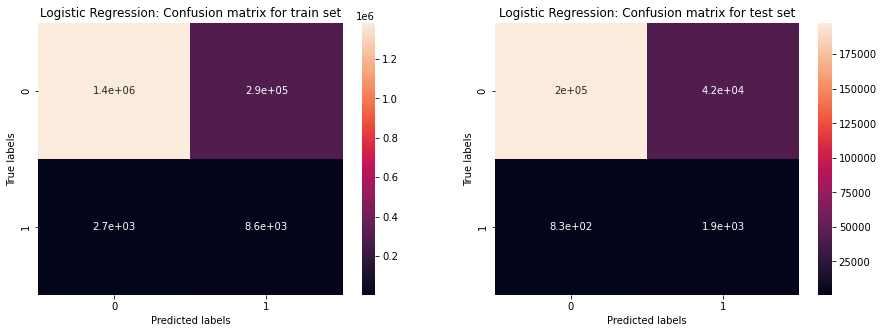

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, logist_y_pred_train), annot=True)
plt.title('Logistic Regression: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, logist_y_pred), annot=True)
plt.title('Logistic Regression: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [27]:
print('The precision score the best logistic regression model on train set is:', precision_score(y_train, logist_y_pred_train, average='macro'))
print('The precision score the best logistic regression model on test set is:', precision_score(y_test, logist_y_pred, average='macro'))

The precision score the best logistic regression model on train set is: 0.5131817899309621
The precision score the best logistic regression model on test set is: 0.5192338806668632


In [28]:
print('The recall score the best logistic regression model on train set is:', recall_score(y_train, logist_y_pred_train, average='macro'))
print('The recall score the best logistic regression model on test set is:', recall_score(y_test, logist_y_pred, average='macro'))

The recall score the best logistic regression model on train set is: 0.7914882886933428
The recall score the best logistic regression model on test set is: 0.7587572726678677


In [29]:
print('The AUC score the best logistic regression model on train set is:', roc_auc_score(y_train, logist_y_pred_train, average='macro'))
print('The AUC score the best logistic regression model on test set is:', roc_auc_score(y_test, logist_y_pred, average='macro'))

The AUC score the best logistic regression model on train set is: 0.7914882886933428
The AUC score the best logistic regression model on test set is: 0.7587572726678677


In [30]:
logist_y_train_pred = best_logist.predict_proba(x_train_scaled)[:,1]
logist_y_test_pred = best_logist.predict_proba(x_test_scaled)[:,1]

In [31]:
train_fpr_logist, train_tpr_logist, train_thresholds_logist = roc_curve(y_train, logist_y_train_pred)
test_fpr_logist, test_tpr_logist, test_thresholds_logist = roc_curve(y_test, logist_y_test_pred)

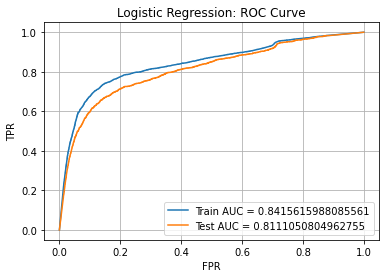

In [32]:
plt.plot(train_fpr_logist, train_tpr_logist, label="Train AUC ="+' '+str(auc(train_fpr_logist, train_tpr_logist)))
plt.plot(test_fpr_logist, test_tpr_logist, label="Test AUC ="+' '+str(auc(test_fpr_logist, test_tpr_logist)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression: ROC Curve")
plt.grid()
plt.show()

# Decision Tree

In [33]:
cart = DecisionTreeClassifier(criterion='gini', class_weight='balanced')

In [34]:
params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

In [35]:
cart_grid_search = GridSearchCV(cart, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [36]:
cart_grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15]},
             return_train_score=True, scoring='roc_auc')

In [37]:
best_max_depth_cart = cart_grid_search.best_estimator_.max_depth

In [38]:
best_cart = DecisionTreeClassifier(criterion='gini', max_depth=best_max_depth_cart, class_weight='balanced')

In [39]:
best_cart.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=8)

In [40]:
cart_y_pred_train = best_cart.predict(x_train)
cart_y_pred = best_cart.predict(x_test)

In [41]:
print('The accuracy score of the decision tree model on train set is:', accuracy_score(y_train, cart_y_pred_train))
print('The accuracy score of the decision tree model on test set is:', accuracy_score(y_test, cart_y_pred))

The accuracy score of the decision tree model on train set is: 0.8645657815221641
The accuracy score of the decision tree model on test set is: 0.8729939068470516


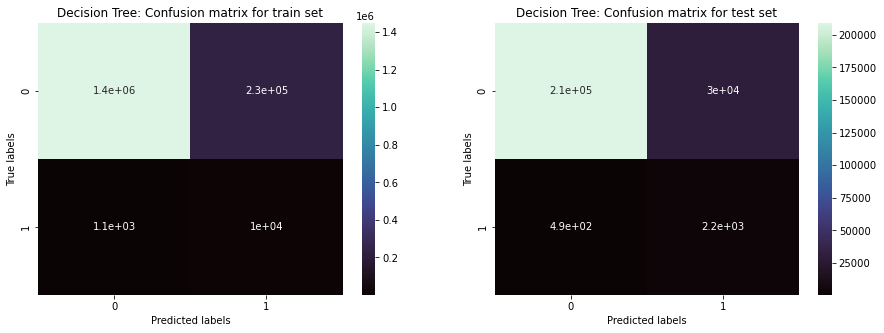

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, cart_y_pred_train), annot=True, cmap='mako')
plt.title('Decision Tree: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, cart_y_pred), annot=True, cmap='mako')
plt.title('Decision Tree: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [43]:
print('The precision score the best decision tree model on train set is:', precision_score(y_train, cart_y_pred_train, average='macro'))
print('The precision score the best decision tree model on test set is:', precision_score(y_test, cart_y_pred, average='macro'))

The precision score the best decision tree model on train set is: 0.5211217424892802
The precision score the best decision tree model on test set is: 0.5327112804470109


In [44]:
print('The recall score the best decision tree model on train set is:', recall_score(y_train, cart_y_pred_train, average='macro'))
print('The recall score the best decision tree model on test set is:', recall_score(y_test, cart_y_pred, average='macro'))

The recall score the best decision tree model on train set is: 0.8845954794088201
The recall score the best decision tree model on test set is: 0.845845435331403


In [45]:
print('The AUC score the best decision tree model on train set is:', roc_auc_score(y_train, cart_y_pred_train, average='macro'))
print('The AUC score the best decision tree model on test set is:', roc_auc_score(y_test, cart_y_pred, average='macro'))

The AUC score the best decision tree model on train set is: 0.8845954794088201
The AUC score the best decision tree model on test set is: 0.8458454353314031


In [46]:
cart_y_train_pred = best_cart.predict_proba(x_train)[:,1]
cart_y_test_pred = best_cart.predict_proba(x_test)[:,1]

In [47]:
train_fpr_cart, train_tpr_cart, train_thresholds_cart = roc_curve(y_train, cart_y_train_pred)
test_fpr_cart, test_tpr_cart, test_thresholds_cart = roc_curve(y_test, cart_y_test_pred)

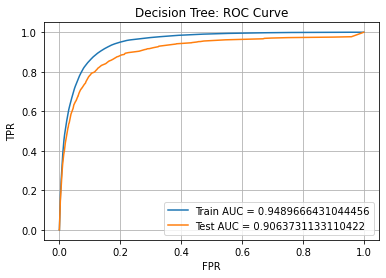

In [48]:
plt.plot(train_fpr_cart, train_tpr_cart, label="Train AUC ="+' '+str(auc(train_fpr_cart, train_tpr_cart)))
plt.plot(test_fpr_cart, test_tpr_cart, label="Test AUC ="+' '+str(auc(test_fpr_cart, test_tpr_cart)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Decision Tree: ROC Curve")
plt.grid()
plt.show()

# Random Forest

In [37]:
#smote = SMOTE()

In [38]:
#x_train, y_train = smote.fit_resample(x_train, y_train)

In [14]:
random_forest = RandomForestClassifier(criterion='gini', n_jobs=-1, class_weight='balanced_subsample')

In [15]:
params = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100], 
          'max_depth':[None, 2, 5, 7, 9, 10, 12, 15, 17, 20, 30, 50]}

In [16]:
forest_random_search = RandomizedSearchCV(random_forest, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [17]:
forest_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 2, 5, 7, 9, 10, 12,
                                                      15, 17, 20, 30, 50],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         35, 40, 45, 50, 75,
                                                         100]},
                   return_train_score=True, scoring='roc_auc')

In [18]:
best_n_estimators_rf = forest_random_search.best_estimator_.n_estimators

In [19]:
best_max_depth_rf = forest_random_search.best_estimator_.max_depth

In [20]:
best_forest = RandomForestClassifier(criterion='gini', n_estimators=best_n_estimators_rf, max_depth=best_max_depth_rf, 
                                     class_weight='balanced_subsample', min_samples_leaf=10, min_samples_split=10, n_jobs=-1)

In [21]:
best_forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=75, n_jobs=-1)

In [22]:
forest_y_pred_train = best_forest.predict(x_train)
forest_y_pred = best_forest.predict(x_test)

In [23]:
print('The accuracy score of the random forest model on train set is:', accuracy_score(y_train, forest_y_pred_train))
print('The accuracy score of the random forest model on test set is:', accuracy_score(y_test, forest_y_pred))

The accuracy score of the random forest model on train set is: 0.9484258173071226
The accuracy score of the random forest model on test set is: 0.9497056697304554


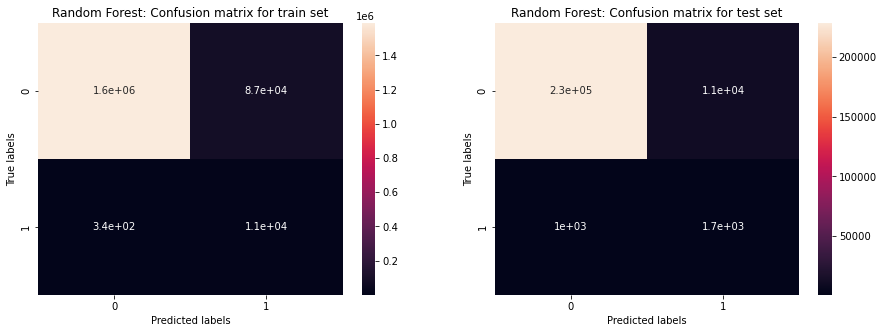

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, forest_y_pred_train), annot=True)
plt.title('Random Forest: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, forest_y_pred), annot=True)
plt.title('Random Forest: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [25]:
print('The precision score the best random forest model on train set is:', precision_score(y_train, forest_y_pred_train, average='macro'))
print('The precision score the best random forest model on test set is:', precision_score(y_test, forest_y_pred, average='macro'))

The precision score the best random forest model on train set is: 0.5559642933964897
The precision score the best random forest model on test set is: 0.5628457615625153


In [26]:
print('The recall score the best random forest model on train set is:', recall_score(y_train, forest_y_pred_train, average='macro'))
print('The recall score the best random forest model on test set is:', recall_score(y_test, forest_y_pred, average='macro'))

The recall score the best random forest model on train set is: 0.9590430599526816
The recall score the best random forest model on test set is: 0.7871526872791855


In [27]:
print('The AUC score the best random forest model on train set is:', roc_auc_score(y_train, forest_y_pred_train, average='macro'))
print('The AUC score the best random forest model on test set is:', roc_auc_score(y_test, forest_y_pred, average='macro'))

The AUC score the best random forest model on train set is: 0.9590430599526817
The AUC score the best random forest model on test set is: 0.7871526872791855


In [28]:
forest_y_train_pred = best_forest.predict_proba(x_train)[:,1]
forest_y_test_pred = best_forest.predict_proba(x_test)[:,1]

In [29]:
train_fpr_forest, train_tpr_forest, train_thresholds_forest = roc_curve(y_train, forest_y_train_pred)
test_fpr_forest, test_tpr_forest, test_thresholds_forest = roc_curve(y_test, forest_y_test_pred)

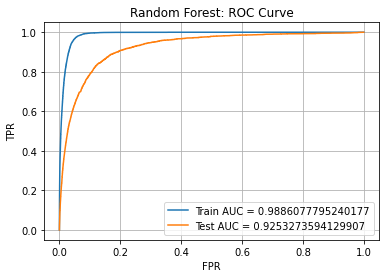

In [30]:
plt.plot(train_fpr_forest, train_tpr_forest, label="Train AUC ="+' '+str(auc(train_fpr_forest, train_tpr_forest)))
plt.plot(test_fpr_forest, test_tpr_forest, label="Test AUC ="+' '+str(auc(test_fpr_forest, test_tpr_forest)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest: ROC Curve")
plt.grid()
plt.show()

# Gradient Boosted Decision Tree

In [31]:
gbdt = XGBClassifier(learning_rate=1e-5, scale_pos_weight=148.0, n_jobs=-1)

In [32]:
params = {'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100], 
          'max_depth':[2, 3, 5, 7, 9, 10, 12, 15, 17, 20, 30, 50]}

In [33]:
gbdt_random_search = RandomizedSearchCV(gbdt, params, cv=5, n_jobs=-1, scoring='roc_auc', return_train_score=True)

In [34]:
gbdt_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=1e-05, max_bin=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=-1,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 5, 7, 9, 10, 12, 15,
                                                      17, 20, 30, 50],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         35, 40, 45, 50, 75,
                                                         100]},
                   return_train_score=True, scoring='roc_auc')

In [35]:
best_n_estimators_gbdt = gbdt_random_search.best_estimator_.n_estimators

In [36]:
best_max_depth_gbdt = gbdt_random_search.best_estimator_.max_depth

In [37]:
best_gbdt = XGBClassifier(n_estimators=best_n_estimators_gbdt, max_depth=best_max_depth_gbdt, learning_rate=1e-6,
                          reg_lambda=0.3, min_child_weight=0.10, subsample=0.6, colsample_bytree=0.7, n_jobs=-1)

In [38]:
best_gbdt.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1e-06, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0,
              min_child_weight=0.1, missing=nan, monotone_constraints='()',
              n_estimators=45, n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=0.3, ...)

In [39]:
gbdt_y_pred_train = best_gbdt.predict(x_train)
gbdt_y_pred = best_gbdt.predict(x_test)

In [40]:
print('The accuracy score of the gradient boosted decision tree model on train set is:', accuracy_score(y_train, gbdt_y_pred_train))
print('The accuracy score of the gradient boosted decision tree model on test set is:', accuracy_score(y_test, gbdt_y_pred))

The accuracy score of the gradient boosted decision tree model on train set is: 0.9949385612550804
The accuracy score of the gradient boosted decision tree model on test set is: 0.988912527109367


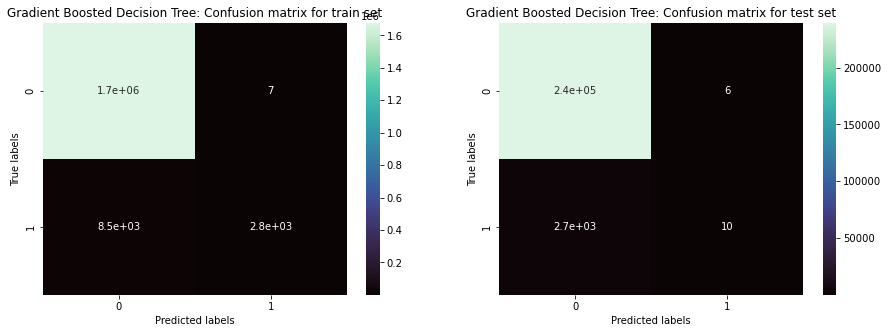

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, gbdt_y_pred_train), annot=True, cmap='mako')
plt.title('Gradient Boosted Decision Tree: Confusion matrix for train set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, gbdt_y_pred), annot=True, cmap='mako')
plt.title('Gradient Boosted Decision Tree: Confusion matrix for test set')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [42]:
print('The precision score the best gradient boosted decision tree model on train set is:', precision_score(y_train, gbdt_y_pred_train, average='macro'))
print('The precision score the best gradient boosted decision tree model on test set is:', precision_score(y_test, gbdt_y_pred, average='macro'))

The precision score the best gradient boosted decision tree model on train set is: 0.9962009258635891
The precision score the best gradient boosted decision tree model on test set is: 0.8069682907886093


In [43]:
print('The recall score the best gradient boosted decision tree model on train set is:', recall_score(y_train, gbdt_y_pred_train, average='macro'))
print('The recall score the best gradient boosted decision tree model on test set is:', recall_score(y_test, gbdt_y_pred, average='macro'))

The recall score the best gradient boosted decision tree model on train set is: 0.6220646794245771
The recall score the best gradient boosted decision tree model on test set is: 0.5018475870387799


In [44]:
print('The AUC score the best gradient boosted decision tree model on train set is:', roc_auc_score(y_train, gbdt_y_pred_train, average='macro'))
print('The AUC score the best gradient boosted decision tree model on test set is:', roc_auc_score(y_test, gbdt_y_pred, average='macro'))

The AUC score the best gradient boosted decision tree model on train set is: 0.622064679424577
The AUC score the best gradient boosted decision tree model on test set is: 0.5018475870387799


In [45]:
gbdt_y_train_pred = best_gbdt.predict_proba(x_train)[:,1]
gbdt_y_test_pred = best_gbdt.predict_proba(x_test)[:,1]

In [46]:
train_fpr_gbdt, train_tpr_gbdt, train_thresholds_gbdt = roc_curve(y_train, gbdt_y_train_pred)
test_fpr_gbdt, test_tpr_gbdt, test_thresholds_gbdt = roc_curve(y_test, gbdt_y_test_pred)

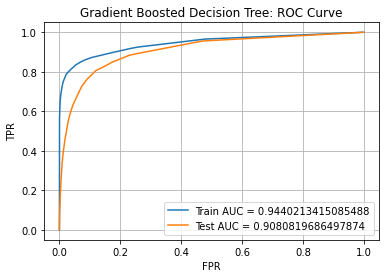

In [47]:
plt.plot(train_fpr_gbdt, train_tpr_gbdt, label="Train AUC ="+' '+str(auc(train_fpr_gbdt, train_tpr_gbdt)))
plt.plot(test_fpr_gbdt, test_tpr_gbdt, label="Test AUC ="+' '+str(auc(test_fpr_gbdt, test_tpr_gbdt)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Gradient Boosted Decision Tree: ROC Curve")
plt.grid()
plt.show()

# Saving best model

We have built 4 models for this case study i.e, Logistic Regression, Decision Tree, Random Forest and Gradient Boosted Decision Tree. Among them we see that Random Forest and Gradient Boosted Decision Tree are the best performing models. Both of them are giving us a perfect score on all the metrics. Therefore, we can finalize either of the models as our best model. For this case study, we are choosing Gradient Boosted Decision Trees as our best model.

In [ ]:
filename = 'best_model_forest.h5'
pickle.dump(best_forest, open(filename, 'wb'))

In [ ]:
best_model = pickle.load(open(filename, 'rb'))

In [ ]:
best_model.predict(x_test)

In [ ]:
accuracy_score(y_test, best_model.predict(x_test))

In [ ]:
y_pred = best_model.predict_proba(x_test)[:,1]

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [ ]:
auc(fpr, tpr)

# Summary

In [ ]:
from prettytable import PrettyTable

summary = PrettyTable()

summary.field_names = ["Model", "Hyperparameters", "Best Value", "Accuracy", "Precision", "Recall", "AUC"]
summary.add_row(['Logistic Regression', 'eta0/penalty', [best_eta0, best_penalty],
                 round(accuracy_score(y_test, logist_y_pred), 3), 
                 round(precision_score(y_test, logist_y_pred), 3), 
                 round(recall_score(y_test, logist_y_pred), 3), 
                 round(auc(test_fpr_logist, test_tpr_logist), 3)])
summary.add_row(['Decision Tree', 'max_depth', best_max_depth_cart,
                 round(accuracy_score(y_test, cart_y_pred), 3), 
                 round(precision_score(y_test, cart_y_pred), 3), 
                 round(recall_score(y_test, cart_y_pred), 3), 
                 round(auc(test_fpr_cart, test_tpr_cart), 3)])
summary.add_row(['Random Forest', 'n_estimators/max_depth', [best_n_estimators_rf, best_max_depth_rf],
                 round(accuracy_score(y_test, forest_y_pred), 3), 
                 round(precision_score(y_test, forest_y_pred), 3), 
                 round(recall_score(y_test, forest_y_pred), 3), 
                 round(auc(test_fpr_forest, test_tpr_forest), 3)])
summary.add_row(['Gradient Boosted Decision Tree', 'n_estimators/max_depth', [best_n_estimators_gbdt, best_max_depth_gbdt], 
                 round(accuracy_score(y_test, gbdt_y_pred), 3), 
                 round(precision_score(y_test, gbdt_y_pred), 3), 
                 round(recall_score(y_test, gbdt_y_pred), 3), 
                 round(auc(test_fpr_gbdt, test_tpr_gbdt), 3)])
print(summary)

We see that tree based models perform way better than linear models. Ensemble models like Random Forest and Gradient Boosted Decision Trees performed the best. We see that the best model is Random Forest model with an AUC of 0.926

# Let's finalize......